In [1]:
import torch
import os
import json
import zipfile
import gzip
import matplotlib.pyplot as plt
from PIL import Image
import torchvision 
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from nltk.corpus import wordnet as wn
import pandas as pd
import numpy as np

In [2]:
import argparse
import os
import random
import shutil
import time
import warnings
from enum import Enum
#from zipfile import ZipFile

from zippedimagefolder import ZippedDatasetFolder
import zippedimagefolder

import torch
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.multiprocessing as mp
import torch.nn as nn
import torch.nn.parallel
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Subset

RUN THE NEXT FEW CELLS ON THE COMMAND LINE, FOR SOME REASON THEY TIMEOUT IN THE NOTEBOOK

In [3]:
# IMAGENET_PATH = '/mnt/home/gkrawezik/ceph/AI_DATASETS/ImageNet/2012/imagenet'

In [4]:
## Check if ImageNet is available in the /tmp folder, otherwise move the zip from imagenet_path and unzip it in /tmp
# if not os.path.exists('/tmp/imagenet'):
#    os.system('cp -r ' + IMAGENET_PATH + ' /tmp/imagenet/')
    #os.system('mkdir /tmp/imagenet/val/ /tmp/imagenet/train/')
    #os.system('unzip val.zip -d /tmp/imagenet/val/')
    #os.system('unzip train.zip -d /tmp/imagenet/train/')

In [5]:
traindirzip = os.path.join('/tmp/imagenet/', 'train.zip')
valdirzip = os.path.join('/tmp/imagenet/', 'val.zip')
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
def unormalize(batch):
    ## batch of shape (batch_size, 3, 224, 224)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1)

    return batch * std + mean

IMG_EXTENSIONS = (".jpg", ".jpeg", ".png", ".ppm", ".bmp", ".pgm", ".tif", ".tiff", ".webp")

train_dataset = ZippedDatasetFolder(
    traindirzip,
    transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ]),
    extensions=IMG_EXTENSIONS)

val_dataset = ZippedDatasetFolder(
    valdirzip,
    transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ]),
    extensions=IMG_EXTENSIONS)

In [6]:
train_dataset[0]

(tensor([[[-1.2103, -1.2274, -1.3302,  ..., -1.0390, -1.0390, -1.0390],
          [-1.2274, -1.2274, -1.3302,  ..., -1.0390, -1.0390, -1.0390],
          [-1.2617, -1.2617, -1.3644,  ..., -1.0390, -1.0390, -1.0390],
          ...,
          [-1.2445, -1.2445, -1.2445,  ..., -0.6794, -0.8849, -0.9020],
          [-1.1932, -1.1932, -1.2103,  ..., -0.5424, -0.7479, -0.7650],
          [-1.1760, -1.1760, -1.2103,  ..., -0.5082, -0.7137, -0.7308]],
 
         [[-1.3179, -1.3354, -1.4055,  ..., -1.0378, -1.0203, -1.0203],
          [-1.3354, -1.3354, -1.4055,  ..., -1.0378, -1.0203, -1.0203],
          [-1.3704, -1.3704, -1.4405,  ..., -1.0203, -1.0203, -1.0203],
          ...,
          [-1.1954, -1.1954, -1.1954,  ..., -0.6702, -0.8803, -0.8978],
          [-1.1429, -1.1429, -1.1604,  ..., -0.5126, -0.7227, -0.7402],
          [-1.1253, -1.1253, -1.1604,  ..., -0.4776, -0.6877, -0.7052]],
 
         [[-1.3339, -1.3513, -1.4384,  ..., -1.1247, -1.1247, -1.1247],
          [-1.3513, -1.3513,

In [7]:
## Get the dictionary of classes for ImageNet

CLASSES_FILE = './classes/imagenet1000_clsidx_to_labels.txt'

with open(CLASSES_FILE) as f:
    idx2classes = eval(f.read())

classes2idx = {v: k for k, v in idx2classes.items()}

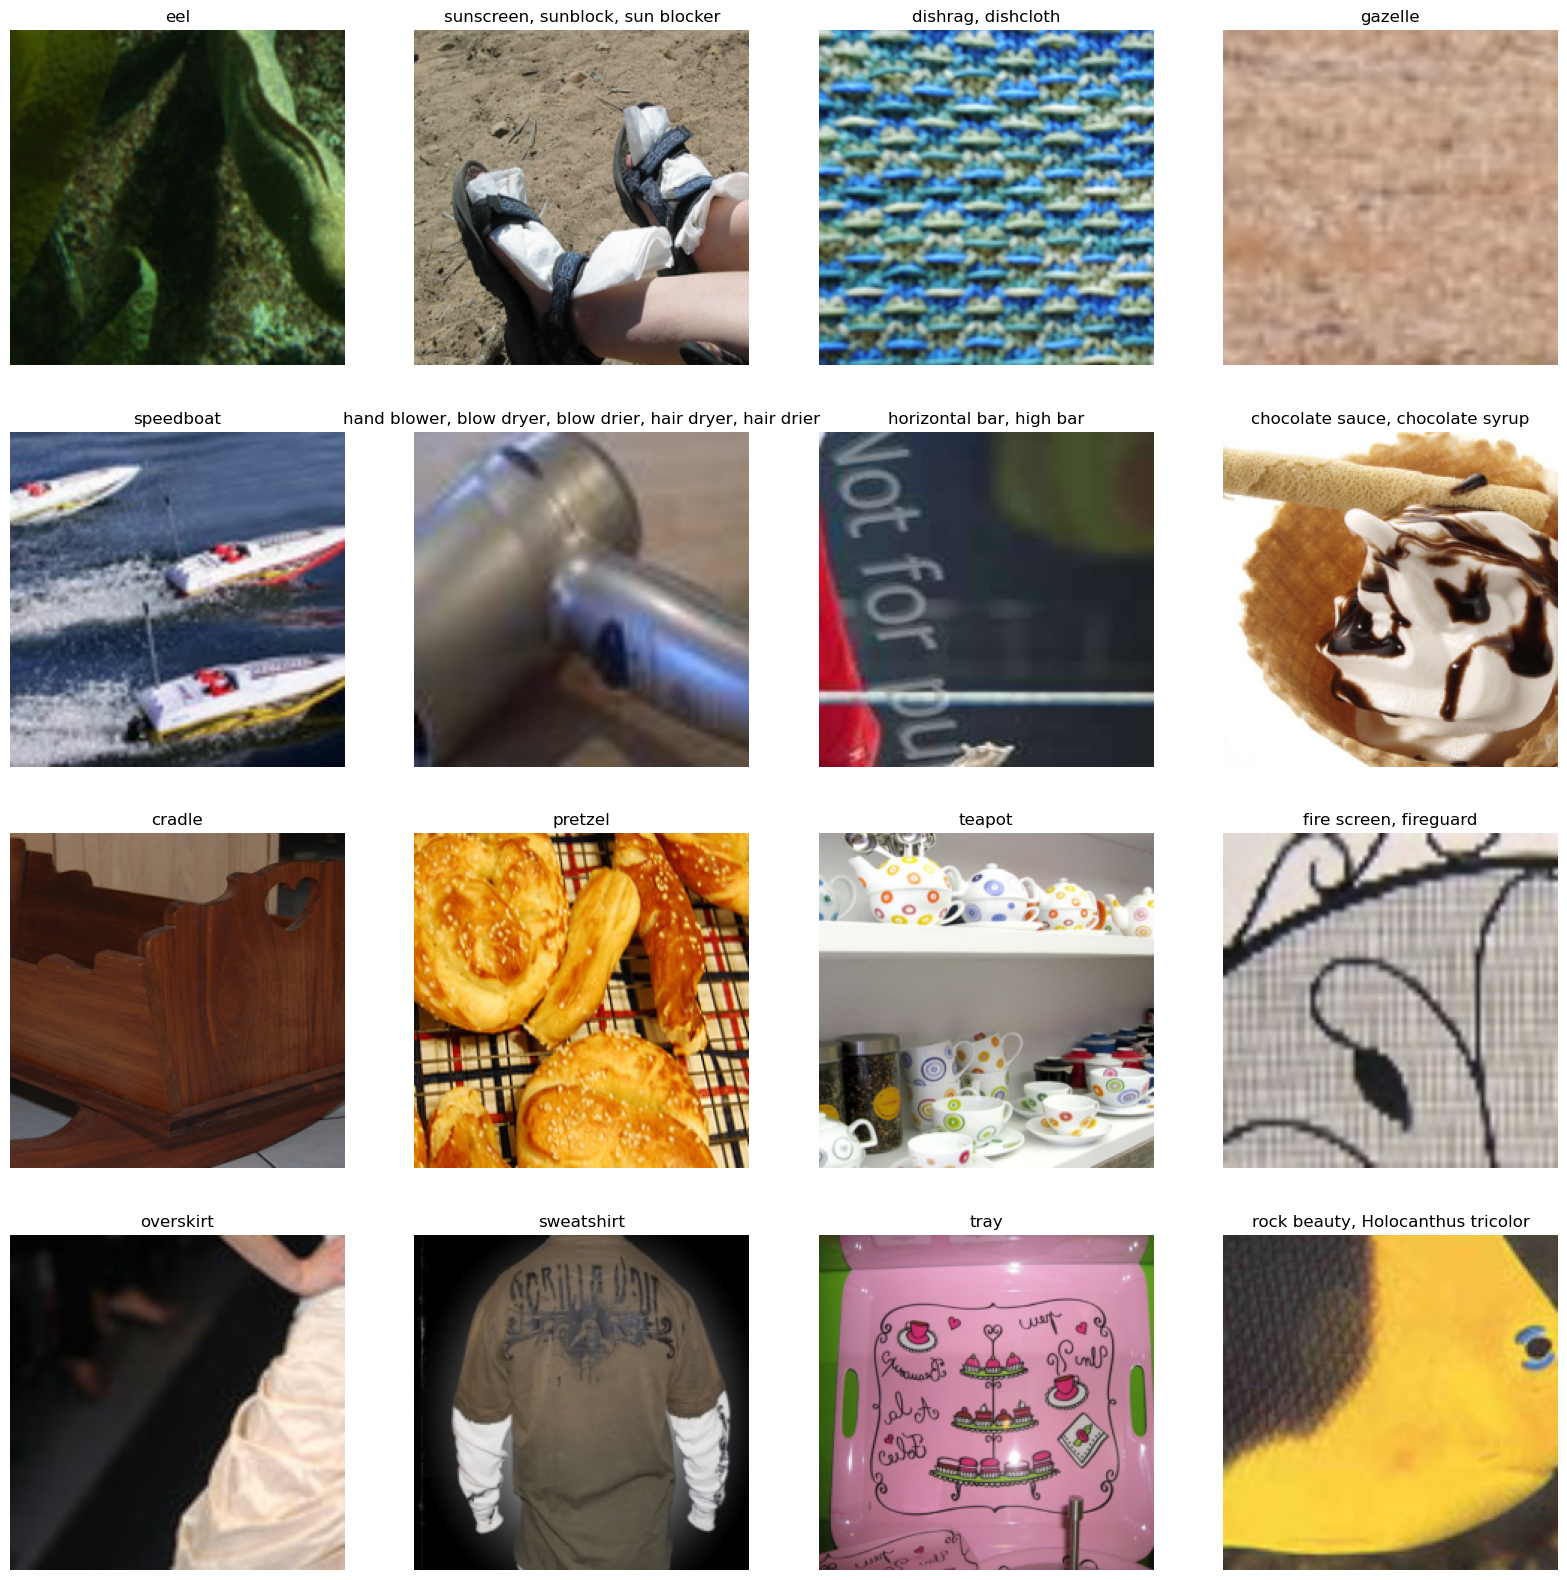

In [8]:
## Print some images from the dataset with their labels


fig, ax = plt.subplots(4, 4, figsize=(20, 20))
for i in range(4):
    for j in range(4):
        idx = random.randint(0, len(train_dataset))
        img, label = train_dataset[idx]
        img = img.unsqueeze_(0)
        ## Clamp the values between 0 and 1 then 255 int
        img = unormalize(img)[0]
        ax[i, j].imshow(img.permute(1, 2, 0))
        ax[i, j].set_title(idx2classes[label])
        ax[i, j].axis('off')

In [9]:
from lucent.optvis import render, param, transform, objectives
from lucent.modelzoo import inceptionv1

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = inceptionv1(pretrained=True)
_ = model.to(device).eval()

In [11]:
## Compute the activations of the model for a given image at layer mixed4a

def get_activations(img, layer):
    img = img.unsqueeze_(0)
    img = img.to(device)
    activations = model(img, end_layer=layer)
    return activations

In [12]:
flag_pop = False
modules_to_pop = []
for l in model._modules:
    if flag_pop:
        modules_to_pop.append(l)
    if l == 'mixed4a':
        flag_pop = True

for module in modules_to_pop:
    model._modules.pop(module)